In [ ]:
# Импортируем необходимые библиотеки
import os
from os import listdir

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Выгружаем архивированные данные из диска
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/ML_course/Задание 5/archive.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/ML_course/archive.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_2

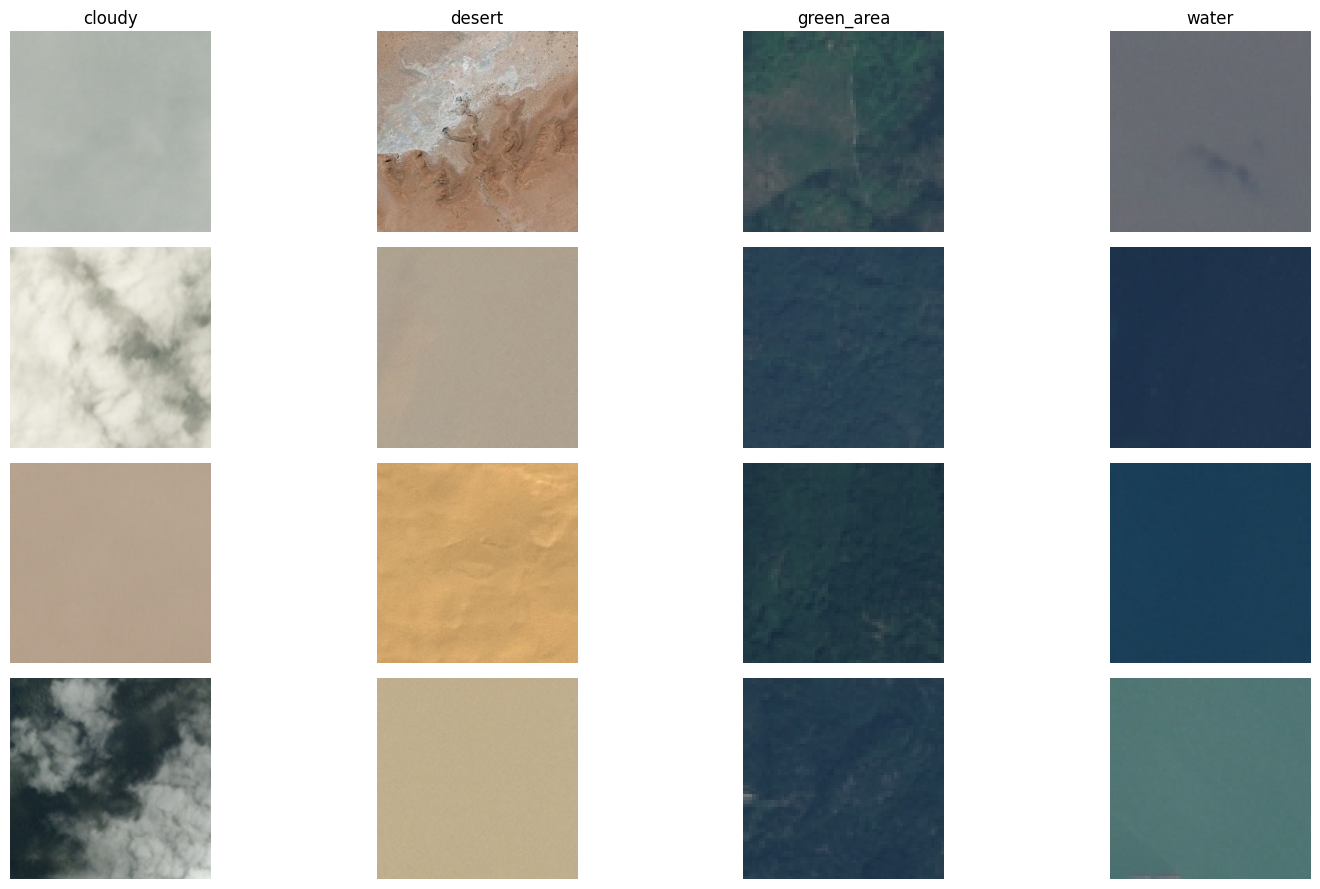

In [ ]:
# Визуализируем данные из архива
dirs = {0: 'cloudy', 1: 'desert', 2: 'green_area', 3: 'water'}
fig, ax = plt.subplots(4,4, figsize=(16,9))
for i in range(4):
  for j in range(4):
    img = Image.open(f'./data/{dirs[j]}/'+np.random.choice(listdir(f'./data/{dirs[j]}')))
    if j==0:
      img = img.convert("RGB") #класс с облаками имеет 4 канала CMYK (cyan, magenta, yellow, key), поэтому нужно его трансформировать в RGB
    ax[i][j].imshow(img)
    ax[i][j].axis('off')
    if i==0:
      ax[i][j].set_title(dirs[j])
plt.tight_layout()

In [ ]:
# Загрузка изображений и сформируем необходимые признаки
X, y = [], []
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Преобразуем изображения в формат 64x64, с нормализацией и векторизацией
  dirs = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
  X, y, k = [], [], 0
  for dir in list(dirs.keys()):
    files=listdir(f'./data/{dir}')
    for f in files:
      img = Image.open(f'./data/{dir}/{f}')
      if dir == 'cloudy':
        img = img.convert("RGB")
      if img.size!=(64,64,3):
        img = img.resize((64, 64))
      img = np.asarray(img, dtype=np.float32) / 255.0  # Нормализуем данные
      X.append(img.reshape(-1))
      y.append(dirs[dir])
      k+=1
    print(f'Dir ./data/{dir} is scanned. Found {len(files)} images')
  print(f'In total {k} images found')

Dir ./data/cloudy is scanned. Found 1500 images
Dir ./data/desert is scanned. Found 1131 images
Dir ./data/green_area is scanned. Found 1500 images
Dir ./data/water is scanned. Found 1500 images
In total 5631 images found


In [ ]:
# Преобразуем X и y в numpy-массивы
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(5631, 12288) (5631,)


In [ ]:
# Делим данные на тестевую и тренировачную выборку
X_train,X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   train_size=0.7,
                                                   random_state=23)

In [ ]:
# Преобразуем данные в тензоры с нужными типами
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Создадим датасеты и генераторы батчей (по 128 примеров)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [ ]:
# Создадим класс с двумя скрытыми слоями
class Classifier(nn.Module):
    def __init__(self, input_size, N, M, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, N) # Первый скрытый слой
        self.fc2 = nn.Linear(N, M) # Второй скрытый слой
        self.out = nn.Linear(M, output_size) # Слой выхода

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Активация ReLU
        x = F.leaky_relu(self.fc2(x)) # Активация LeakyReLU
        return self.out(x)

In [ ]:
# Зададим параметры обучения и инициализации
epochs = 10
lr = 0.001
input_shape = 64 * 64 * 3
hidden1 = 512
hidden2 = 256
output_shape = 4

In [ ]:
model = Classifier(input_shape, hidden1, hidden2, output_shape)
loss_fn = nn.CrossEntropyLoss() # Выбираем функцию потерь для классификации
optimizer = optim.Adam(model.parameters(), lr=lr) # Используем Адам-оптимизатор

In [ ]:
# Создадим цикл для обучения модели
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

In [ ]:
# Оцениваем качество модели на тестовых данных
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # логиты
        predicted = torch.argmax(outputs, dim=1)  # индексы классов
        all_preds.extend(predicted.cpu().numpy())  # ← добавлено .cpu() на случай GPU
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, Accuracy={acc:.4f}")

Epoch 10: Loss=0.3810, Accuracy=0.8444


После 10 эпох обучения модель достигла точности 84.44% на тестовой выборке, при значении функции потерь 0.3810. Это говорит о хорошем качестве классификации спутниковых изображений с использованием MLP.